In [138]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import json
import numpy as np

In [139]:
CRIME_CSV_PATH = "./db/aichi-crime-2020.csv"
crime_df = pd.read_csv(CRIME_CSV_PATH)
display(crime_df.head())

,id,crime,trick,police_station,police_box,city_code,prefecture,city,number,date,time,place,place_name,lat,lon,relevance
0,crime-00001,窃盗,部品ねらい,西,名塚,231045,愛知県,名古屋市西区,天塚町４丁目,2019-09-11,20,その他の住宅（３階建て以下共同住宅等）,"日本, 愛知県名古屋市西区天塚町4丁目",35.200157,136.892705,0.99
1,crime-00002,窃盗,部品ねらい,西,名塚,231045,愛知県,名古屋市西区,上堀越町２丁目,2019-08-05,18,駐車（輪）場,"日本, 愛知県名古屋市西区上堀越町2丁目",35.204867,136.881139,0.99
2,crime-00003,窃盗,部品ねらい,西,名塚,231045,愛知県,名古屋市西区,上堀越町３丁目,2019-05-23,08,駐車（輪）場,"日本, 愛知県名古屋市西区上堀越町3丁目",35.204543,136.879850,0.99
3,crime-00004,窃盗,部品ねらい,西,名塚,231045,愛知県,名古屋市西区,香呑町１丁目,2019-03-10,17,駐車（輪）場,"日本, 愛知県名古屋市西区香呑町1丁目",35.203126,136.899371,0.99
4,crime-00005,窃盗,部品ねらい,西,名塚,231045,愛知県,名古屋市西区,香呑町１丁目,2019-03-11,19,駐車（輪）場,"日本, 愛知県名古屋市西区香呑町1丁目",35.203126,136.899371,0.99


In [140]:
crime_df.isnull().sum()

id                 0
crime              0
trick              0
police_station     0
police_box         0
city_code          0
prefecture         0
city               0
number             0
date               0
time               0
place              0
place_name        19
lat                0
lon                0
relevance          0
dtype: int64

In [156]:
# GeoJSONに変換
record_list = []

for index,row in crime_df.iterrows():
    
    id = row[0]

    crime = row[1]
    trick = row[2]
    police_station = row[3]
    police_box = row[4]
    city_code = row[5]
    prefecture = row[6]
    city = row[7]
    number = row[8]
    date = row[9]
    time = row[10]
    place = row[11]
    place_name = row[12]
    lat = row[13]
    lon = row[14]
    relevance = row[15]
    
    record = {
        "type": "Feature",
        "geometry": {
            "type": "Point",
            "coordinates": [lon, lat],
        },
        "properties": {
            "id": id,
            "crime": crime,
            "trick": trick,
            "police_station": police_station,
            "police_box": police_box,
            "city_code": city_code,
            "prefecture": prefecture,
            "city": city,
            "number": number,
            "date": date,
            "time": time,
            "place": place,
            "place_name": place_name,
            "relevance": relevance
        }
    }
    
    record_list.append(record)

In [157]:
# レコード数
print(len(record_list))

45456


In [158]:
# 最初のレコード
print(record_list[0]["geometry"]["coordinates"])

[136.892705485502, 35.2001569561191]


In [159]:
# GeoJSONに変換
geojson = {
    "type": "FeatureCollection",
    "features": []
}

geojson["features"] = record_list

# GeoJSONファイルを書込
with open("aichi-crime-2020.geojson", "w") as f:
    json.dump(geojson, f, ensure_ascii=False)

In [160]:
crime_gdf = gpd.read_file("aichi-crime-2020.geojson")
print(len(crime_gdf))

45456


In [161]:
crime_gdf[0:1]

,id,crime,trick,police_station,police_box,city_code,prefecture,city,number,date,time,place,place_name,relevance,geometry
0,crime-00001,窃盗,部品ねらい,西,名塚,231045,愛知県,名古屋市西区,天塚町４丁目,2019-09-11,20,その他の住宅（３階建て以下共同住宅等）,"日本, 愛知県名古屋市西区天塚町4丁目",0.99,POINT (136.89271 35.20016)


In [162]:
crime_gdf.geometry

0        POINT (136.89271 35.20016)
1        POINT (136.88114 35.20487)
2        POINT (136.87985 35.20454)
3        POINT (136.89937 35.20313)
4        POINT (136.89937 35.20313)
                    ...            
45451    POINT (137.26951 34.66724)
45452    POINT (137.26951 34.66724)
45453    POINT (137.26951 34.66724)
45454    POINT (137.26951 34.66724)
45455    POINT (137.27330 34.67386)
Name: geometry, Length: 45456, dtype: geometry

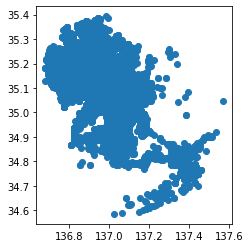

In [170]:
crime_gdf[crime_gdf["relevance"] > 0.8].plot()